In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import geeksw.hgcal.testbeam as hgc
import scipy
from scipy.optimize import curve_fit
import time
from scipy.special import erf

In [ ]:
#electron_runlist = hgc.runlist.query("Particle == 'electron'").groupby("Energy").apply(lambda x : x.iloc[2])
electron_runlist = hgc.runlist.query("Energy == '250'").query("Particle == 'electron'")

In [3]:
def grindhammer(t, alpha, beta, E):
    return E * ((beta*t)**(alpha-1)*beta*np.exp(-beta*t)) / scipy.special.gamma(alpha)

In [4]:
def fitting(X0, energy):
    return curve_fit(grindhammer, X0, energy, p0 = [5.47, 0.5, 23000])

In [5]:
def f(x, mu, sigma, N):
    return N * np.exp(-(x - mu)**2/(2*sigma**2))

In [6]:
def gaus(x,mu, sigma, A ):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


def crystalball(x, a, n, xb, sig):
    x = x + 0j
    if a < 0:
        a = -a
    if n < 0:
        n = -n
    aa = abs(a)
    A = (n / aa) ** n * np.exp(-aa ** 2 / 2)
    B = n / aa - aa
    C = n / aa * 1 / (n - 1) * np.exp(-aa ** 2 / 2)
    D = np.sqrt(np.pi / 2) * (1 + erf(aa / np.sqrt(2)))
    N = 1.0 / (sig * (C + D))
    total = 0.0 * x
    total += ((x - xb) / sig > -a) * N * np.exp(-(x - xb) ** 2 / (2.0 * sig ** 2))
    total += ((x - xb) / sig <= -a) * N * A * (B - (x - xb) / sig) ** (-n)
    return total.real
    try:
        return total.real
    except:
        return total
    return total


def gausexp(x,  mu, sigma, N,k):
    if k < 0:
        k = -k

    total = 0.0 * x
    total += ((x - mu) / sigma > -k) * N * np.exp(-(x - mu) ** 2 / (2.0 * sigma ** 2))
    total += ((x - mu) / sigma <= -k) * N * np.exp(k ** 2 / 2.0 + k * ((x - mu) / sigma))

    return total

In [7]:
hdf = hgc.load_run(665, columns = ["beamEnergy","event", "rechit_layer", "rechit_energy", "rechit_X0", "rechit_dE"])

In [8]:
#hdf = hdf.groupby("event").apply(lambda x : x.iloc[0])
E = []
start = time.time()
p0 = [5.47, 0.5, 23000]
for i in range(0,1000): 
    hdff = hdf.loc[i]
    hdff = hdff.groupby("rechit_X0").sum()
    hdff = hdff.reset_index()
    popt, pcov = curve_fit(grindhammer, hdff.rechit_X0, hdff.rechit_energy, p0, maxfev = 20000)
    E.append(popt[2])
end = time.time()
end-start

57.13957190513611

In [43]:
popt

array([4.62740503e+00, 4.69584264e-01, 1.49840851e+04])

In [10]:
E = pd.DataFrame(data = dict(x=E))#
p = pd.DataFrame.quantile(E,[0.16,1.0])
p1 = p.x[0.16]
p2 = p.x[1.0]

17790.368720836937


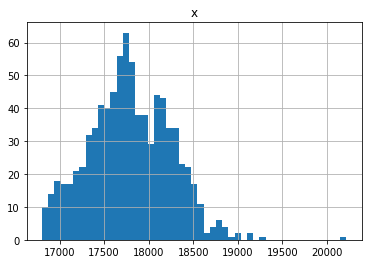

In [11]:
bins = np.linspace(p1, p2, 50)
E.hist(bins=bins)
npoints, bin_edges = list(np.histogram(E, bins=bins))
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.
binmean = (npoints*bin_centers).sum()/(npoints.sum())
print (binmean)

[1.08754025 1.09748221 1.10742418 1.11736614 1.1273081  1.13725007
 1.14719203 1.15713399 1.16707595 1.17701792 1.18695988 1.19690184
 1.2068438  1.21678577 1.22672773 1.23666969 1.24661166 1.25655362
 1.26649558 1.27643754 1.28637951 1.29632147 1.30626343 1.31620539
 1.32614736 1.33608932 1.34603128 1.35597324 1.36591521 1.37585717
 1.38579913 1.3957411  1.40568306 1.41562502 1.42556698 1.43550895
 1.44545091 1.45539287 1.46533483 1.4752768  1.48521876 1.49516072
 1.50510269 1.51504465 1.52498661 1.53492857 1.54487054 1.5548125
 1.56475446]
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.5 0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
49
49


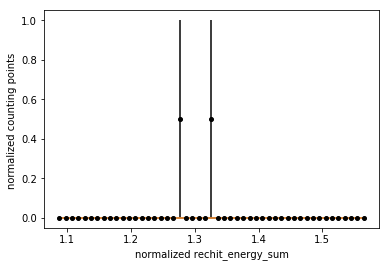

In [13]:
energy_sums = hdf.query("rechit_layer <= 28").groupby("event")["rechit_energy"].sum().values
bins = np.linspace(20000, 29000, 50)
counts, bin_edges = np.histogram(energy_sums, bins=bins)
counts = np.array(counts, dtype=np.float)
counts_uncert = np.sqrt(counts)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.

scale = np.median(energy_sums)
bin_edges = bin_edges / scale
bin_centers = bin_centers / scale
counts_uncert = counts_uncert / np.sum(counts)
counts = counts / np.sum(counts)


def  plot_energy_sum_fit (f, **kwargs):
    popt, pcov = curve_fit(f, bin_centers, counts)
    plt.plot(bin_centers, f(bin_centers, *popt), **kwargs)
    return popt
print (bin_centers)
print (counts)
print (len(bin_centers))
print (len(counts))
plt.errorbar(bin_centers, counts, yerr=counts_uncert, fmt='o', markersize=4, color='k')
popt_gaus = plot_energy_sum_fit(gaus, label="Gaussian")
popt_crystalball = plot_energy_sum_fit(crystalball, label="Crystal ball")
popt_gausexp = plot_energy_sum_fit(gausexp, label="Gaussian with exponential tail")
#plt.legend(loc="upper left")
plt.xlabel("normalized rechit_energy_sum")
plt.ylabel("normalized counting points ")
plt.show()

[0.90957818 0.91334575 0.91711333 0.9208809  0.92464848 0.92841606
 0.93218363 0.93595121 0.93971878 0.94348636 0.94725394 0.95102151
 0.95478909 0.95855666 0.96232424 0.96609182 0.96985939 0.97362697
 0.97739454 0.98116212 0.9849297  0.98869727 0.99246485 0.99623242
 1.         1.00376758 1.00753515 1.01130273 1.0150703  1.01883788
 1.02260546 1.02637303 1.03014061 1.03390818 1.03767576 1.04144334
 1.04521091 1.04897849 1.05274606 1.05651364 1.06028122 1.06404879
 1.06781637 1.07158394 1.07535152 1.0791191  1.08288667 1.08665425
 1.09042182]
[0.01190476 0.01666667 0.02142857 0.0202381  0.0202381  0.025
 0.02619048 0.03809524 0.04047619 0.04880952 0.04761905 0.05357143
 0.06666667 0.075      0.06428571 0.0452381  0.0452381  0.03452381
 0.05238095 0.05119048 0.04047619 0.04047619 0.02738095 0.02619048
 0.0202381  0.01309524 0.00238095 0.0047619  0.00714286 0.0047619
 0.00119048 0.00238095 0.         0.00238095 0.         0.00119048
 0.         0.         0.         0.         0.        

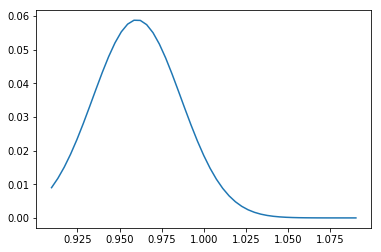

In [47]:
Resolution = []
bin_centers = bin_centers/np.median(bin_centers)
npoints = npoints/np.sum(npoints)
popt, pcov = curve_fit(gaus, bin_centers, npoints, maxfev = 2000)# ,p0 = [22000,1000,300]
print (bin_centers)
print(npoints)
print (popt)
print (popt[1]/popt[0])
plt.plot(bin_centers, gaus(bin_centers, *popt))
#plt.plot(bin_centers,npoints)
#plt.hist(E,bins=bins,histtype = "step")
plt.show()

/opt/exp_soft/llr/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/opt/exp_soft/llr/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in reciprocal


[1. 1. 1. 1.]
1.0


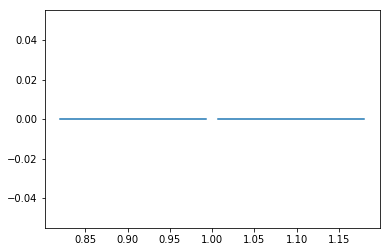

In [37]:
bin_centers = bin_centers/np.median(bin_centers)
npoints = npoints/np.sum(npoints)
popt, pcov = curve_fit(crystalball, bin_centers, npoints, maxfev = 2000, p0 = [0.77, 0.02, 0.17, 0.20])#
print (popt)
print (popt[1]/popt[0])
plt.plot(bin_centers, crystalball(bin_centers, *popt))
plt.show()

[0.96085599 0.02532144 0.05939771 1.01182247]
0.026353006953174267


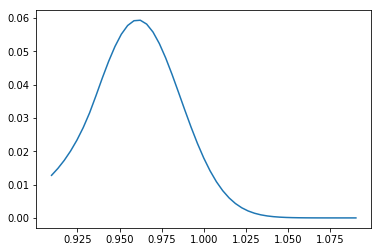

In [48]:
bin_centers = bin_centers/np.median(bin_centers)
npoints = npoints/np.sum(npoints)
popt, pcov = curve_fit(gausexp, bin_centers, npoints, maxfev = 2000, p0 = [0.9,0.017,0.1693,0.204])#, p0 = [22000,1000,300]
print (popt)
print (popt[1]/popt[0])
plt.plot(bin_centers, gausexp(bin_centers, *popt))
plt.show()

0.04479090888716153


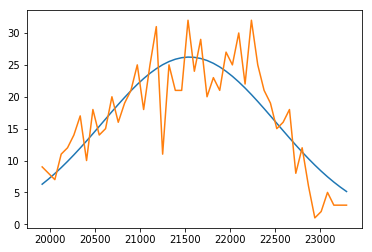

In [11]:
Resolution = []
popt, pcov = curve_fit(f, bin_centers, npoints, p0 = [22000,1000,300], maxfev = 2000)
print (popt[1]/popt[0])
plt.plot(bin_centers, f(bin_centers, *popt))
plt.plot(bin_centers,npoints)
#plt.hist(E,bins=bins,histtype = "step")
plt.xlabel("rechitEnergy_sum")
plt.ylabel("number of counts")
plt.show()

In [9]:
hdf = hgc.load_run(386, columns = ["beamEnergy","event", "rechit_layer", "rechit_energy", "rechit_X0", "rechit_dE"])

Text(0, 0.5, 'number of counts')

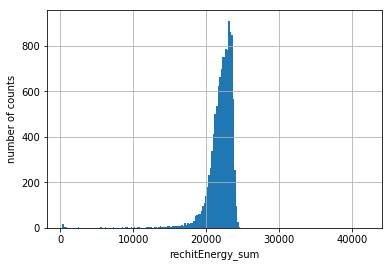

In [19]:
rechit_energy_sum = hdf.groupby("event").rechit_energy.sum()
rechit_energy_sum = rechit_energy_sum.reset_index()
rechit_energy_sum.rechit_energy.hist(bins=200)
plt.xlabel("rechitEnergy_sum")
plt.ylabel("number of counts")

In [20]:
p = pd.DataFrame.quantile(rechit_energy_sum,[0.16,0.99])
k1 = p.rechit_energy[0.16]
k2 = p.rechit_energy[0.99]
print(k1,k2)

20882.731796875 24093.793437499997


22546.057591583634


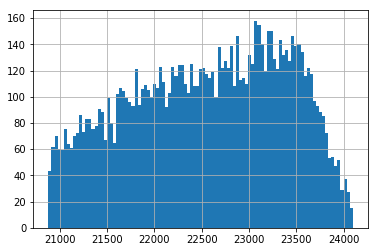

In [21]:
bins = np.linspace(k1, k2, 100)
rechit_energy_sum.rechit_energy.hist(bins=bins)
npoints, bin_edges = list(np.histogram(rechit_energy_sum.rechit_energy, bins=bins))
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.
binmean = (npoints*bin_centers).sum()/(npoints.sum())
print (binmean)
nbin_centers = []
for bin_cen in bin_centers:
    nbin_centers.append(bin_cen/10000)

0.05536907169919379


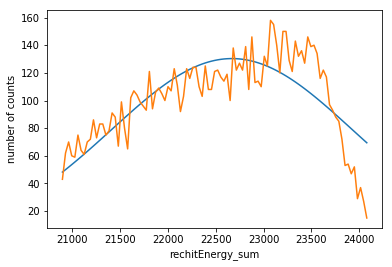

In [22]:
Resolution = []
popt, pcov = curve_fit(f, bin_centers, npoints, p0 = [22000,1000,300], maxfev = 2000)
print (popt[1]/popt[0])
plt.plot(bin_centers, f(bin_centers, *popt))
plt.plot(bin_centers,npoints)
#plt.hist(E,bins=bins,histtype = "step")
plt.xlabel("rechitEnergy_sum")
plt.ylabel("number of counts")
plt.show()